In [6]:
from sympy import *
init_printing(use_latex=1)

# SymPy-符号运算好帮手

## 从例子开始

### 封面上的经典公式

虚单位: I

In [7]:
E**(I*pi) + 1

创建符号对象, 展开数学表达式: expend()

In [8]:
x = symbols("x") 
expand( E**(I*x) )

In [10]:
# 将表达式展开为实部和虚部
expand(exp(I*x), complex=True)

In [11]:
%P expand(exp(I*x), complex=True)

!expand(exp(I*x), complex=True)>: I*exp(-im(x))*sin(re(x)) + exp(-im(x))*cos(re(x)),    


$\Re\Im$分别表示实部和虚部

In [14]:
box("ℜℑ")

        二进制    八进制    十进制    十六进制    Unicode
--------------  --------  --------  ----------  ---------
10000100011100     20434      8476      0x211c          ℜ
10000100010001     20421      8465      0x2111          ℑ


In [7]:
x = Symbol("x", real=True) # 指定 x 为实数
expand(exp(I*x), complex=True)    

将函数$e^{ix}$展开为泰勒多项式

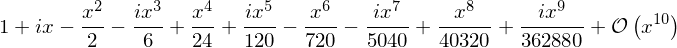

In [16]:
tmp = series(exp(I*x), x, 0, 10)
tmp

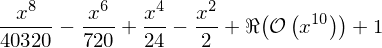

In [9]:
re(tmp) # e^(ix) 实数项之和应该等于cos(x)的泰勒展开

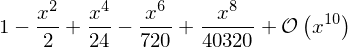

In [10]:
series(cos(x), x, 0, 10)

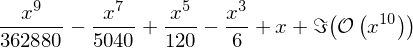

In [11]:
im(tmp) # e^(ix) 虚数项之和应该等于sin(x)的泰勒展开

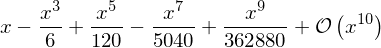

In [12]:
series(sin(x), x, 0, 10)

### 球体体积

intergrate(): 计算符号积分

In [18]:
integrate(x*sin(x), x) # 计算不定积分

In [19]:
integrate(x*sin(x), (x, 0, 2*pi)) #计算定积分

In [29]:
f = symbols('f', cls=Function)
r = symbols('r', positive=True)

圆的面积公式: $S = 2 \int_{- r}^{r} f{\left (x \right )}\, dx$.  
* 从微矩形极限和的角度理解: $dx$是矩形微元的底, $f(x)$是矩形微元的高;

In [42]:
x, y = symbols('x, y')
r = symbols('r', positive=True) # 圆的半径为正
circle_area = 2 * integrate(sqrt(r**2 - x**2), (x, -r, r))
circle_area

圆的体积公式: $V = \pi \int_{- r}^{r} f^{2}{\left (x \right )}\, dx $ .  
* 从微圆柱极限和的角度, $\pi f^{2}{\left (x \right )}$, 其中$f{\left (x \right )} = \sqrt{r^2-x^2}$是微圆柱的底面积, $dx$是微圆柱的高;
* ``expr2latex('pi*Integral(f(x)**2,(x,-r,r))')``

In [43]:
circle_area = circle_area.subs(r, sqrt(r**2 - x**2))
circle_area

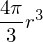

In [44]:
# 球的体积
integrate(circle_area, (x, -r, r))

expr.sub(): 使用新的符号对象,替换原有的符号对象:  
* sub(x,y): 将表达式中的x替换为y;  
* sub({x:y, u:v}): 使用字典进行多次替换, 将表达式中的x替换为y, 表达式中的u替换为v;  
* subs([(x,y),(u,v)]): 使用列表进行多次替换, 多次替换操作是串行的而不是并行的;

In [47]:
kk 1

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>!kk1>进行>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


### 数值微分

In [18]:
x = symbols('x', real=True)
h = symbols('h', positive=True)
f = symbols('f', cls=Function) # 定义表示数学函数的符号f

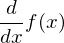

In [19]:
f_diff = f(x).diff(x, 1) # f(x)是sympy可识别的符号
f_diff

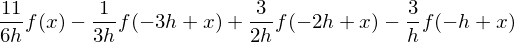

In [20]:
# 导数的N点公式:更精确的导数公式
expr_diff = as_finite_diff(f_diff, [x, x-h, x-2*h, x-3*h])
expr_diff

比较数值求导与符号求导的误差

In [21]:
sym_dexpr = f_diff.subs(f(x), x*exp(-x**2)).doit()
sym_dexpr

In [8]:
sym_dfunc = lambdify([x], sym_dexpr, modules="numpy")
sym_dfunc(np.array([-1, 0, 1]))

array([-0.36787944,  1.        , -0.36787944])

In [9]:
print expr_diff.args

(-3*f(-h + x)/h, -f(-3*h + x)/(3*h), 3*f(-2*h + x)/(2*h), 11*f(x)/(6*h))


In [26]:
w = Wild("w")
c = Wild("c")
patterns = [arg.match(c * f(w)) for arg in expr_diff.args]

In [27]:
print patterns[0]

{w_: -h + x, c_: -3/h}


In [28]:
coefficients = [t[c] for t in sorted(patterns, key=lambda t:t[w])]
print coefficients

[-1/(3*h), 3/(2*h), -3/h, 11/(6*h)]


In [29]:
coeff_arr = np.array([float(coeff.subs(h, 1e-3)) for coeff in coefficients])
print coeff_arr

[ -333.33333333  1500.         -3000.          1833.33333333]


In [30]:
def moving_window(x, size):
    from numpy.lib.stride_tricks import as_strided    
    x = np.ascontiguousarray(x)
    return as_strided(x, shape=(x.shape[0] - size + 1, size), 
                      strides=(x.itemsize, x.itemsize))

x_arr = np.arange(-2, 2, 1e-3)
y_arr = x_arr * np.exp(-x_arr * x_arr)
num_res = (moving_window(y_arr, 4) * coeff_arr).sum(axis=1)
sym_res = sym_dfunc(x_arr[3:])
print np.max(abs(num_res - sym_res))

4.08944167418e-09


In [31]:
def finite_diff_coefficients(f_diff, order, h):
    v = f_diff.variables[0]
    points = [x - i * h for i in range(order)]
    expr_diff = as_finite_diff(f_diff, points)
    w = Wild("w")
    c = Wild("c")
    patterns = [arg.match(c*f(w)) for arg in expr_diff.args]
    coefficients = np.array([float(t[c]) 
                             for t in sorted(patterns, key=lambda t:t[w])])
    return coefficients

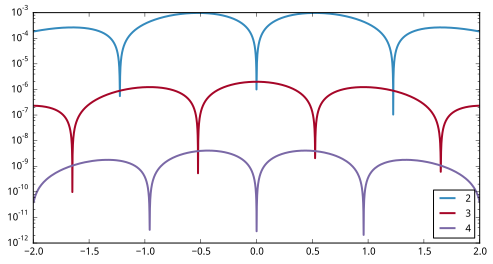

In [32]:
#%figonly=比较不同点数的数值微分的误差
fig, ax = pl.subplots(figsize=(8, 4))

for order in range(2, 5):
    c = finite_diff_coefficients(f_diff, order, 1e-3)
    num_diff = (moving_window(y_arr, order) * c).sum(axis=1)
    sym_diff = sym_dfunc(x_arr[order-1:])
    error = np.abs(num_diff - sym_diff)
    ax.semilogy(x_arr[order-1:], error, label=str(order))
    
ax.legend(loc="best");